In [1]:
from PIL import Image
import glob
import cv2 
import numpy as np
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.optim import *
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random
import os
from os import listdir
from os.path import isfile, join

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
PATH = '/Dataset'
PATH2 = '/models/'
batch_size = 4
lrG = 0.0002
lrD = 0.0002
beta1 = 0.5
beta2 = 0.999
L1lambda = 100
num_epochs = 15

In [3]:
transform = albumentations.Compose([
    albumentations.Resize(256, 256), 
    #albumentations.RandomCrop(224, 224),
    #albumentations.HorizontalFlip(), # Same with transforms.RandomHorizontalFlip()
    albumentations.pytorch.transforms.ToTensor()
])

In [4]:
#import glob
#import cv2 as cv
#path = glob.glob("/path/to/folder/*.jpg")
#cv_img = []
#for img in path:
#    n = cv.imread(img)
#    cv_img.append(n)

In [5]:
onlyfiles = [file for file in glob.glob(os.getcwd()+PATH+"/*") if file.endswith('.png') or file.endswith('.PNG')]
images = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(PATH, onlyfiles[n]) )

In [6]:
class CustomDataset(Dataset):

    def __init__(self, file, transform=None):
        self.file = file
        self.transform = transform
        
    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):
        img = self.file[idx]
        sketch_image = cv2.cvtColor(img[:,:256,:], cv2.COLOR_BGR2RGBA)
        real_image = cv2.cvtColor(img[:,256:,:], cv2.COLOR_BGR2RGBA)
        if self.transform:
            augmented1 = self.transform(image=sketch_image) 
            image1 = augmented1['image']
            augmented2 = self.transform(image= real_image) 
            image2 = augmented2['image']
        return image1, image2

In [7]:
dataset = CustomDataset(images, transform)

In [8]:
dataloader =DataLoader(dataset, batch_size=1, shuffle=True)

### BasicBlock

In [151]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, kernal_size, stride, padding):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernal_size,
                               stride=stride, padding=padding, dilation=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=2,
                               stride=1, padding=1, dilation=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        self.isShortCut = False
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            self.isShortCut = True
        else :
            self.isShortCut = False
            
        self.hyperparms = [in_planes, planes, kernal_size, stride, padding]
        self.leaky = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        shortcutLayer = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leaky(out)
        
        out += shortcutLayer
        #print("ShortCut 사용 여부 : {0}".format(self.isShortCut))
        return out

In [152]:
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_planes, planes, kernal_size, stride, padding):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_planes, planes, kernel_size=kernal_size,
                               stride=stride, padding=padding, dilation=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.ConvTranspose2d(planes, planes, kernel_size=2,
                               stride=1, padding=1, dilation=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        self.isShortCut = False
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            self.isShortCut = True
        else :
            self.isShortCut = False
            
        self.hyperparms = [in_planes, planes, kernal_size, stride, padding]
        self.leaky = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        shortcutLayer = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leaky(out)
        
        out += shortcutLayer
        #print("ShortCut 사용 여부 : {0}".format(self.isShortCut))
        return out

### UNet

In [153]:
# U-net 구조를 만들어보자
class Generator(nn.Module):
  def __init__(self, ngf=64): ### Question -> why self.conv_bn no?
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(4, ngf, kernel_size=4, stride=2, padding=1) #(3, 256, 256)->(64, 128, 128)
    self.in_planes = ngf
    
    self.conv2 = nn.Conv2d(ngf, ngf*2, 4, 2, 1) #(64, 128, 128)->(128, 64, 64)
    self.conv2_bn = nn.BatchNorm2d(ngf*2) 
    self.conv3 = nn.Conv2d(ngf*2, ngf*4, 4, 2, 1) #(128, 64, 64)->(256, 32, 32)
    self.conv3_bn = nn.BatchNorm2d(ngf*4) 
    
    
    
    self.conv4 = nn.Conv2d(ngf*4, ngf*8, 4, 2, 1) #(256, 32, 32)->(512, 16, 16)
    self.conv4_bn = nn.BatchNorm2d(ngf*8) 
    self.conv5 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 16, 16)->(512, 8, 8)
    self.conv5_bn = nn.BatchNorm2d(ngf*8) 
    
    
    self.conv6 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 4, 4)
    self.conv6_bn = nn.BatchNorm2d(ngf*8) 
    self.conv7 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 2, 2)
    self.conv7_bn = nn.BatchNorm2d(ngf*8) 
    
    
    self.conv8 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 1, 1)
    self.conv8_bn = nn.BatchNorm2d(ngf*8) 

    self.deconv0 = nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1) #(512, 1, 1)->(512, 2, 2)  # concat 했으니까 수정해야함
    self.deconv0_bn = nn.BatchNorm2d(ngf*8) 
    self.deconv1 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 4, 4)
    self.deconv1_bn = nn.BatchNorm2d(ngf*8) 
    
    self.deconv2 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 8, 8)
    self.deconv2_bn = nn.BatchNorm2d(ngf*8) 
    self.deconv3 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 16, 16)
    self.deconv3_bn = nn.BatchNorm2d(ngf*8) 
    
    self.deconv4 = nn.ConvTranspose2d(ngf*8*2, ngf*4, 4, 2, 1) #(512, 16, 16)->(256, 32, 32)
    self.deconv4_bn = nn.BatchNorm2d(ngf*4) 
    self.deconv5 = nn.ConvTranspose2d(ngf*4*2, ngf*2, 4, 2, 1) #(256, 32, 32)->(128, 64, 64)
    self.deconv5_bn = nn.BatchNorm2d(ngf*2) 
    
    self.deconv6 = nn.ConvTranspose2d(ngf*2*2, ngf, 4, 2, 1) #(128, 64, 64)->(64, 128, 128)
    self.deconv6_bn = nn.BatchNorm2d(ngf) 
    self.deconv7 = nn.ConvTranspose2d(ngf*2, 4, 4, 2, 1) #(64, 128, 128)->(3, 256, 256)

    self.leaky = nn.LeakyReLU(0.2, True)
    self.relu = nn.ReLU(True)
    self.drop = nn.Dropout(0.5)
    

    
  def forward(self, input): # (3, 256, 256) <- input
    x1 = self.conv1(input) #(64, 128, 128)<- x1

    x2 = self.leaky(x1)
    x2 = self.conv2(x1)
    x2 = self.conv2_bn(x2)

    x3 = self.leaky(x2)   
    x3 = self.conv3(x3)
    x3 = self.conv3_bn(x3)

    x4 = self.leaky(x3)  
    x4 = self.conv4(x4)
    x4 = self.conv4_bn(x4)  

    x5 = self.leaky(x4)
    x5 = self.conv5(x5)    
    x5 = self.conv5_bn(x5)  

    x6 = self.leaky(x5)
    x6 = self.conv6(x6)    
    x6 = self.conv6_bn(x6)

    x7 = self.leaky(x6)
    x7 = self.conv7(x7)
    x7 = self.conv7_bn(x7)

    x8 = self.leaky(x7)
    x8 = self.conv8(x7)

    y1 = self.relu(x8)
    y1 = self.deconv0(y1)
    y1 = self.deconv0_bn(y1)
    y1 = self.drop(y1)
    y1 = torch.cat([y1,x7], dim=1)

    y2 = self.relu(y1)
    y2 = self.deconv1(y2)
    y2 = self.deconv1_bn(y2)
    y2 = self.drop(y2)
    y2 = torch.cat([y2,x6], dim=1)

    y3 = self.relu(y2)
    y3 = self.deconv2(y3)
    y3 = self.deconv2_bn(y3)
    y3 = self.drop(y3)
    y3 = torch.cat([y3,x5], dim=1)

    y4 = self.relu(y3)
    y4 = self.deconv3(y4)
    y4 = self.deconv3_bn(y4)
    y4 = torch.cat([y4,x4], dim=1)

    y5 = self.relu(y4)
    y5 = self.deconv4(y5)
    y5 = self.deconv4_bn(y5)
    y5 = torch.cat([y5,x3], dim=1)

    y6 = self.relu(y5)
    y6 = self.deconv5(y6)
    y6 = self.deconv5_bn(y6)
    y6 = torch.cat([y6,x2], dim=1)

    y7 = self.relu(y6)
    y7 = self.deconv6(y7)
    y7 = self.deconv6_bn(y7)
    y7 = torch.cat([y7,x1], dim=1)

    y8 = self.relu(y7)
    y8 = self.deconv7(y8)

    output = nn.Tanh()(y8)

    return output

In [154]:
# U-net 구조를 만들어보자
class AllShortcutResGenerator(nn.Module):    
    def __init__(self, ngf=64): ### Question -> why self.conv_bn no?
        super(AllShortcutResGenerator, self).__init__()
        self.in_planes=ngf

        self.conv1 = nn.Conv2d(4, ngf, kernel_size=4, stride=2, padding=1) #(3, 256, 256)->(64, 128, 128)

        self.conv2 = BasicBlock(ngf, ngf*2, 4, 2, 1) #(64, 128, 128)->(128, 64, 64)
        self.conv2_bn = nn.BatchNorm2d(ngf*2) 
        self.conv3 = BasicBlock(ngf*2, ngf*4, 4, 2, 1) #(128, 64, 64)->(256, 32, 32)
        self.conv3_bn = nn.BatchNorm2d(ngf*4) 

        self.conv4 = BasicBlock(ngf*4, ngf*8, 4, 2, 1) #(256, 32, 32)->(512, 16, 16)
        self.conv4_bn = nn.BatchNorm2d(ngf*8) 
        self.conv5 = BasicBlock(ngf*8, ngf*8, 4, 2, 1) #(512, 16, 16)->(512, 8, 8)
        self.conv5_bn = nn.BatchNorm2d(ngf*8) 

        self.conv6 = BasicBlock(ngf*8, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 4, 4)
        self.conv6_bn = nn.BatchNorm2d(ngf*8) 
        self.conv7 = BasicBlock(ngf*8, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 2, 2)
        self.conv7_bn = nn.BatchNorm2d(ngf*8) 

        #self.conv2, self.conv3 = self.conv2d_make_layer(ngf*4, 2, 4, 2, 1)
        #self.conv4, self.conv5 = self.conv2d_make_layer(ngf*8, 2, 4, 2, 1)
        #self.conv6, self.conv7 = self.conv2d_make_layer(ngf*8, 2, 4, 2, 1)

        self.conv8 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 1, 1)
        #self.conv8_basic = BasicBlock(ngf*8, ngf*8, 4, 1, 1)
        self.conv8_bn = nn.BatchNorm2d(ngf*8) 

        #self.deconv0 = nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1) #(512, 1, 1)->(512, 2, 2)  # concat 했으니까 수정해야함
        #self.deconv0_bn = nn.BatchNorm2d(ngf*8) 

        #self.convs = self._conv_make_layer(ngf*2, 7, 4, 2, 1)

        self.deconv0 = nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1) #(512, 1, 1)->(512, 2, 2)  # concat 했으니까 수정해야함
        self.deconv0_bn = nn.BatchNorm2d(ngf*8) 
        
        self.deconv1 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 4, 4)
        self.deconv1_bn = nn.BatchNorm2d(ngf*8) 
        self.deconv2 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 8, 8)
        self.deconv2_bn = nn.BatchNorm2d(ngf*8) 
        
        self.deconv3 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 16, 16)
        self.deconv3_bn = nn.BatchNorm2d(ngf*8) 
        self.deconv4 = nn.ConvTranspose2d(ngf*8*2, ngf*4, 4, 2, 1) #(512, 16, 16)->(256, 32, 32)
        self.deconv4_bn = nn.BatchNorm2d(ngf*4) 
        
        self.deconv5 = nn.ConvTranspose2d(ngf*4*2, ngf*2, 4, 2, 1) #(256, 32, 32)->(128, 64, 64)
        self.deconv5_bn = nn.BatchNorm2d(ngf*2) 
        self.deconv6 = nn.ConvTranspose2d(ngf*2*2, ngf, 4, 2, 1) #(128, 64, 64)->(64, 128, 128)
        self.deconv6_bn = nn.BatchNorm2d(ngf) 
        
        self.deconv7 = nn.ConvTranspose2d(ngf*2, 4, 4, 2, 1) #(64, 128, 128)->(3, 256, 256)

        #self.deconvs = self._tconv_make_layer(ngf*8, 7, 4, 2, 1)

        #self.leaky = nn.LeakyReLU(0.2, True)
        self.leaky = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU(True)
        self.drop = nn.Dropout(0.5)
    
    def conv2d_make_layer(self, planes, num_blocks, kernel_size, stride, padding):
        strides = [stride] + [2]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, kernel_size, stride, padding))
            self.in_planes = planes
        return tuple(layers)
    
    def tconv2d_make_layer(self, planes, num_blocks, kernel_size, stride, padding):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, kernel_size, stride, padding))
            self.in_planes = planes
        return tuple(layers)
    
    

    def forward(self, input): # (3, 256, 256) <- input
        #print("입력 사이즈 : {0}".format(input.shape))
        x1 = self.conv1(input) #(64, 128, 128)<- x1
        #print("기본 conv 사이즈 : {0}".format(x1.shape))
        #x2 = self.convs(x1)
        #x3 = self.deconvs(x2)
        #output = nn.Tanh()(x3)
        
        
        #x2 = self.leaky(x1)
        x2 = self.conv2(x1)
        #x2 = self.conv2_bn(x2)
        #print("1차 사이즈 : {0}".format(x2.shape))

        #x3 = self.leaky(x2)   
        x3 = self.conv3(x2)
        #x3 = self.conv3_bn(x3)
        #print("2차 사이즈 : {0}".format(x3.shape))
        
        #x4 = self.leaky(x3)  
        x4 = self.conv4(x3)
        #x4 = self.conv4_bn(x4)  
        #print("3차 사이즈 : {0}".format(x4.shape))
        
        #x5 = self.leaky(x4)
        x5 = self.conv5(x4)    
        #x5 = self.conv5_bn(x5)  
        #print("4차 사이즈 : {0}".format(x5.shape))
    
        #x6 = self.leaky(x5)
        x6 = self.conv6(x5)    
        #x6 = self.conv6_bn(x6)
        #print("5차 사이즈 : {0}".format(x6.shape))

        #x7 = self.leaky(x6)
        x7 = self.conv7(x6)
        #x7 = self.conv7_bn(x7)
        #print("6차 사이즈 : {0}".format(x7.shape))
       
        #x2 = self.conv1_bas(x1)
        #x3 = self.conv2_bas(x2)
        #x7 = self.conv3_bas(x3)

        x8 = self.leaky(x7)
        x8 = self.conv8(x8)
        
        #x8 = self.conv8_basic(x7)
        #print("7차 사이즈 : {0}".format(x8.shape))

        y1 = self.relu(x8)
        y1 = self.deconv0(y1)
        y1 = self.deconv0_bn(y1)
        y1 = self.drop(y1)
        y1 = torch.cat([y1,x7], dim=1)
        #print("8차 사이즈 : {0}".format(y1.shape))

        y2 = self.relu(y1)
        y2 = self.deconv1(y2)
        y2 = self.deconv1_bn(y2)
        y2 = self.drop(y2)
        y2 = torch.cat([y2,x6], dim=1)
        #print("9차 사이즈 : {0}".format(y2.shape))

        y3 = self.relu(y2)
        y3 = self.deconv2(y3)
        y3 = self.deconv2_bn(y3)
        y3 = self.drop(y3)
        y3 = torch.cat([y3,x5], dim=1)
        #print("9차 사이즈 : {0}".format(y3.shape))

        y4 = self.relu(y3)
        y4 = self.deconv3(y4)
        y4 = self.deconv3_bn(y4)
        y4 = torch.cat([y4,x4], dim=1)
        #print("10차 사이즈 : {0}".format(y4.shape))

        y5 = self.relu(y4)
        y5 = self.deconv4(y5)
        y5 = self.deconv4_bn(y5)
        y5 = torch.cat([y5,x3], dim=1)
        #print("11차 사이즈 : {0}".format(y5.shape))

        y6 = self.relu(y5)
        y6 = self.deconv5(y6)
        y6 = self.deconv5_bn(y6)
        y6 = torch.cat([y6,x2], dim=1)
        #print("12차 사이즈 : {0}".format(y6.shape))

        y7 = self.relu(y6)
        y7 = self.deconv6(y7)
        y7 = self.deconv6_bn(y7)
        y7 = torch.cat([y7,x1], dim=1)
        #print("13차 사이즈 : {0}".format(y7.shape))

        y8 = self.relu(y7)
        y8 = self.deconv7(y8)
        #print("14차 사이즈 : {0}".format(y8.shape))

        output = nn.Tanh()(y8)
        #print("출력 사이즈 : {0}".format(output.shape))
        
        return output

In [155]:
# U-net 구조를 만들어보자
class ResGenerator(nn.Module):    
    def __init__(self, ngf=64): ### Question -> why self.conv_bn no?
        super(ResGenerator, self).__init__()
        self.in_planes=ngf

        self.conv1 = nn.Conv2d(4, ngf, kernel_size=4, stride=2, padding=1) #(3, 256, 256)->(64, 128, 128)

        self.conv2 = BasicBlock(ngf, ngf*2, 4, 2, 1) #(64, 128, 128)->(128, 64, 64)
        self.conv2_bn = nn.BatchNorm2d(ngf*2) 
        self.conv3 = BasicBlock(ngf*2, ngf*4, 4, 2, 1) #(128, 64, 64)->(256, 32, 32)
        self.conv3_bn = nn.BatchNorm2d(ngf*4) 

        self.conv4 = BasicBlock(ngf*4, ngf*6, 4, 2, 1) #(256, 32, 32)->(512, 16, 16)
        self.conv4_bn = nn.BatchNorm2d(ngf*6) 
        self.conv5 = BasicBlock(ngf*6, ngf*6, 3, 1, 1) #(512, 16, 16)->(512, 8, 8)
        self.conv5_bn = nn.BatchNorm2d(ngf*6) 
        
        self.conv6 = BasicBlock(ngf*6, ngf*8, 4, 2, 1) #(256, 32, 32)->(512, 16, 16)
        self.conv6_bn = nn.BatchNorm2d(ngf*8) 
        self.conv7 = BasicBlock(ngf*8, ngf*8, 3, 1, 1) #(512, 16, 16)->(512, 8, 8)
        self.conv7_bn = nn.BatchNorm2d(ngf*8) 

        self.conv8 = BasicBlock(ngf*8, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 4, 4)
        self.conv8_bn = nn.BatchNorm2d(ngf*8) 
        self.conv9 = BasicBlock(ngf*8, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 2, 2)
        self.conv9_bn = nn.BatchNorm2d(ngf*8) 

        #self.conv2, self.conv3 = self.conv2d_make_layer(ngf*4, 2, 4, 2, 1)
        #self.conv4, self.conv5 = self.conv2d_make_layer(ngf*8, 2, 4, 2, 1)
        #self.conv6, self.conv7 = self.conv2d_make_layer(ngf*8, 2, 4, 2, 1)

        self.conv10 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 1, 1)
        #self.conv8_basic = BasicBlock(ngf*8, ngf*8, 4, 1, 1)
        self.conv10_bn = nn.BatchNorm2d(ngf*8) 

        #self.deconv0 = nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1) #(512, 1, 1)->(512, 2, 2)  # concat 했으니까 수정해야함
        #self.deconv0_bn = nn.BatchNorm2d(ngf*8) 

        #self.convs = self._conv_make_layer(ngf*2, 7, 4, 2, 1)

        self.deconv0 = nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1) #(512, 1, 1)->(512, 2, 2)  # concat 했으니까 수정해야함
        self.deconv0_bn = nn.BatchNorm2d(ngf*8) 
        self.deconv1 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 4, 4)
        self.deconv1_bn = nn.BatchNorm2d(ngf*8) 
        
        self.deconv2 = nn.ConvTranspose2d(ngf*8*2, ngf*4*2, 4, 2, 1) #(512, 4, 4)->(512, 8, 8)
        self.deconv2_bn = nn.BatchNorm2d(ngf*8) 
        self.deconv3 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 3, 1, 1) #(512, 8, 8)->(512, 16, 16)
        self.deconv3_bn = nn.BatchNorm2d(ngf*8) 
        
        self.deconv4 = nn.ConvTranspose2d(ngf*8*2, ngf*6, 4, 2, 1) #(512, 16, 16)->(256, 32, 32)
        self.deconv4_bn = nn.BatchNorm2d(ngf*6) 
        self.deconv5 = nn.ConvTranspose2d(ngf*6*2, ngf*6, 3, 1, 1) #(512, 8, 8)->(512, 16, 16)
        self.deconv5_bn = nn.BatchNorm2d(ngf*6) 
        
        self.deconv6 = nn.ConvTranspose2d(ngf*6*2, ngf*4, 4, 2, 1) #(512, 16, 16)->(256, 32, 32)
        self.deconv6_bn = nn.BatchNorm2d(ngf*4) 
        self.deconv7 = nn.ConvTranspose2d(ngf*4*2, ngf*2, 4, 2, 1) #(256, 32, 32)->(128, 64, 64)
        self.deconv7_bn = nn.BatchNorm2d(ngf*2) 
        
        self.deconv8 = nn.ConvTranspose2d(ngf*2*2, ngf, 4, 2, 1) #(128, 64, 64)->(64, 128, 128)
        self.deconv8_bn = nn.BatchNorm2d(ngf) 
        
        self.deconv9 = nn.ConvTranspose2d(ngf*2, 4, 4, 2, 1) #(64, 128, 128)->(3, 256, 256)

        #self.deconvs = self._tconv_make_layer(ngf*8, 7, 4, 2, 1)

        #self.leaky = nn.LeakyReLU(0.2, True)
        self.leaky = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU(True)
        self.drop = nn.Dropout(0.5)
    
    def conv2d_make_layer(self, planes, num_blocks, kernel_size, stride, padding):
        strides = [stride] + [2]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, kernel_size, stride, padding))
            self.in_planes = planes
        return tuple(layers)
    
    def tconv2d_make_layer(self, planes, num_blocks, kernel_size, stride, padding):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, kernel_size, stride, padding))
            self.in_planes = planes
        return tuple(layers)
    
    

    def forward(self, input): # (3, 256, 256) <- input
        x1 = self.conv1(input) #(64, 128, 128)<- x1
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)    
        x6 = self.conv6(x5)    
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        x9 = self.conv9(x8)
        
        x10 = self.leaky(x9)
        x10 = self.conv10(x10)
        
        y1 = self.relu(x10)
        y1 = self.deconv0(y1)
        y1 = self.deconv0_bn(y1)
        y1 = self.drop(y1)
        y1 = torch.cat([y1,x9], dim=1)

        y2 = self.relu(y1)
        y2 = self.deconv1(y2)
        y2 = self.deconv1_bn(y2)
        y2 = self.drop(y2)
        y2 = torch.cat([y2,x8], dim=1)

        y3 = self.relu(y2)
        y3 = self.deconv2(y3)
        y3 = self.deconv2_bn(y3)
        y3 = self.drop(y3)
        y3 = torch.cat([y3,x7], dim=1)

        y4 = self.relu(y3)
        y4 = self.deconv3(y4)
        y4 = self.deconv3_bn(y4)
        y4 = torch.cat([y4,x6], dim=1)

        y5 = self.relu(y4)
        y5 = self.deconv4(y5)
        y5 = self.deconv4_bn(y5)
        y5 = torch.cat([y5,x5], dim=1)

        y6 = self.relu(y5)
        y6 = self.deconv5(y6)
        y6 = self.deconv5_bn(y6)
        y6 = torch.cat([y6,x4], dim=1)
        
        y7 = self.relu(y6)
        y7 = self.deconv6(y7)
        y7 = self.deconv6_bn(y7)
        y7 = torch.cat([y7,x3], dim=1)

        y8 = self.relu(y7)
        y8 = self.deconv7(y8)
        y8 = self.deconv7_bn(y8)
        y8 = torch.cat([y8,x2], dim=1)

        y9 = self.relu(y8)
        y9 = self.deconv8(y9)
        y9 = self.deconv8_bn(y9)
        y9 = torch.cat([y9,x1], dim=1)
        
        y10 = self.relu(y9)
        y10 = self.deconv9(y10)

        output = nn.Tanh()(y10)
        
        return output

In [156]:
class Discriminator(nn.Module): # 70*70 Patch
  def __init__(self, ndf=64):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(8, ndf, 4, 2, 1) 
    self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(ndf*2)
    self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(ndf*4)
    self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 1, 1)
    self.conv4_bn = nn.BatchNorm2d(ndf*8)
    self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 1)

    self.leaky = nn.LeakyReLU(0.2, True)

  def forward(self, input, label):
    x = torch.cat([input,label], dim=1)
    x = self.conv1(x)
    x = self.leaky(x)
    x = self.conv2(x)
    x = self.conv2_bn(x)
    x = self.leaky(x)
    x = self.conv3(x)
    x = self.conv3_bn(x)
    x = self.leaky(x)
    x = self.conv4(x)
    x = self.conv4_bn(x)
    x = self.leaky(x)
    x = self.conv5(x)
    output = nn.Sigmoid()(x)

    return output

In [157]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [158]:
def testpic():
    onlyfilesT = [file for file in glob.glob(os.getcwd()+"/TestDataset/*") if file.endswith('.png') or file.endswith('.PNG')]
    imagesT = np.empty(len(onlyfilesT), dtype=object)
    print(onlyfilesT)
    for n in range(0, len(onlyfilesT)):
      imagesT[n] = cv2.imread(onlyfilesT[n])

    dataloaderT = DataLoader(CustomDataset(imagesT, transform), batch_size=1, shuffle=True)
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")

    num = 0
    for i, data in enumerate(dataloaderT):
        if(num>=1) :
            break
        num+=1
        x = data[0]
        y = data[1]

        pic = netG(x)
        pic = np.transpose(pic.detach().numpy()[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()

In [159]:
netG = ResGenerator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

ResGenerator(
  (conv1): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky): LeakyReLU(negative_slope=0.2)
  )
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

In [160]:
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Conv2d(8, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (leaky): LeakyReLU(negative_slope=0.2, inplace=True)
)


In [161]:
real_label = 1.
fake_label = 0.
img_list = []
G_loss = []
D_loss = []


In [162]:
def fit(num_epochs=1000):
  print("Starting Training Loop...")
  optimizerG = Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))
  optimizerD = Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
  iters = 0
  for epoch in range(num_epochs):
    print(f"EPOCH{epoch+1}:")
    train_one_epoch(dataloader, netG, netD, optimizerG, optimizerD, epoch)


def train_one_epoch(dataloader, netG, netD, optimizerG, optimizerD, epoch, iters=0):
    with torch.autograd.set_detect_anomaly(True):
      for i, data in enumerate(dataloader):

            netD.zero_grad()
            sketch, real = data
            sketch, real = sketch.to(device), real.to(device)

            D_real = netD(sketch, real).view(-1)
            # Calculate loss on all-real batch
            label = torch.full((D_real.size(0),), real_label, device=device)
            errD_real = nn.BCELoss()(D_real, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = D_real.mean().item()

            # Generate fake image batch with G
            fake = netG(sketch)
            label.fill_(fake_label)
            # Classify all fake batch with D
            D_fake = netD(sketch, fake.detach()).view(-1)

            # Calculate D's loss on the all-fake batch
            errD_fake = nn.BCELoss()(D_fake, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = D_fake.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            D_output = netD(sketch, fake).view(-1)
            G_output = netG(sketch)
            # Calculate G's loss based on this output
            errG = nn.BCELoss()(D_output, label)+ nn.L1Loss()(G_output, real)*L1lambda
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = D_output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 1 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_loss.append(errG.item())
            D_loss.append(errD.item())

            if(iters%100==0) :
                testpic()

            # Check how the generator is doing
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(sketch).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1


Starting Training Loop...
EPOCH1:
[0/15][0/11]	Loss_D: 1.7086	Loss_G: 79.8684	D(x): 0.5850	D(G(z)): 0.5840 / 0.4264
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png', 'F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\109.png', 'F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\110.png', 'F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\111.png', 'F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\112.png', 'F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\113.png', 'F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\114.png']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


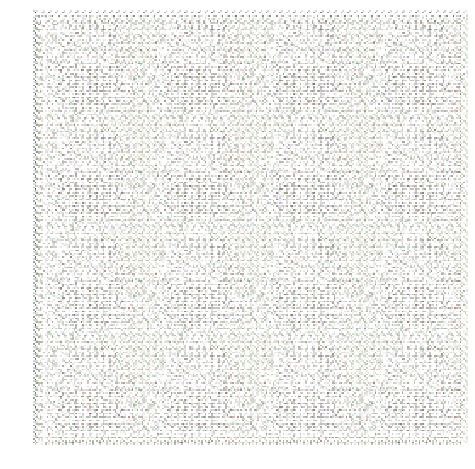

[0/15][1/11]	Loss_D: 1.7676	Loss_G: 79.0296	D(x): 0.5079	D(G(z)): 0.4680 / 0.4219
[0/15][2/11]	Loss_D: 1.7136	Loss_G: 74.6252	D(x): 0.4938	D(G(z)): 0.4320 / 0.4074
[0/15][3/11]	Loss_D: 1.3863	Loss_G: 71.9973	D(x): 0.5255	D(G(z)): 0.4248 / 0.3991
[0/15][4/11]	Loss_D: 1.2812	Loss_G: 70.2744	D(x): 0.5791	D(G(z)): 0.4348 / 0.3918
[0/15][5/11]	Loss_D: 1.4078	Loss_G: 66.8269	D(x): 0.5856	D(G(z)): 0.4306 / 0.3786
[0/15][6/11]	Loss_D: 1.1571	Loss_G: 62.5042	D(x): 0.6298	D(G(z)): 0.4264 / 0.3497
[0/15][7/11]	Loss_D: 1.1832	Loss_G: 61.4596	D(x): 0.6114	D(G(z)): 0.3864 / 0.2985
[0/15][8/11]	Loss_D: 1.2281	Loss_G: 57.3612	D(x): 0.6139	D(G(z)): 0.3851 / 0.2994
[0/15][9/11]	Loss_D: 1.0561	Loss_G: 56.5196	D(x): 0.6197	D(G(z)): 0.3419 / 0.2996
[0/15][10/11]	Loss_D: 1.0231	Loss_G: 52.8016	D(x): 0.6504	D(G(z)): 0.3444 / 0.2844
EPOCH2:
[1/15][0/11]	Loss_D: 0.8437	Loss_G: 51.7707	D(x): 0.6978	D(G(z)): 0.3207 / 0.2355
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


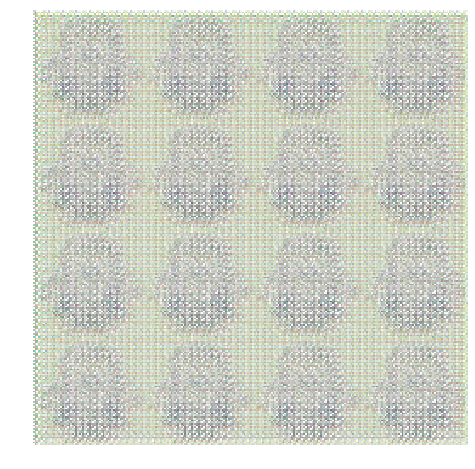

[1/15][1/11]	Loss_D: 0.8520	Loss_G: 49.7967	D(x): 0.7191	D(G(z)): 0.3316 / 0.2481
[1/15][2/11]	Loss_D: 0.8772	Loss_G: 46.2538	D(x): 0.6787	D(G(z)): 0.2921 / 0.2104
[1/15][3/11]	Loss_D: 0.6707	Loss_G: 44.5929	D(x): 0.7313	D(G(z)): 0.2615 / 0.1975
[1/15][4/11]	Loss_D: 0.8078	Loss_G: 43.1563	D(x): 0.7317	D(G(z)): 0.2955 / 0.2021
[1/15][5/11]	Loss_D: 0.7905	Loss_G: 41.3680	D(x): 0.7190	D(G(z)): 0.2674 / 0.1550
[1/15][6/11]	Loss_D: 0.5788	Loss_G: 38.1294	D(x): 0.7545	D(G(z)): 0.2145 / 0.1523
[1/15][7/11]	Loss_D: 0.5953	Loss_G: 37.4491	D(x): 0.7881	D(G(z)): 0.2518 / 0.1617
[1/15][8/11]	Loss_D: 0.4650	Loss_G: 35.6849	D(x): 0.7775	D(G(z)): 0.1701 / 0.1441
[1/15][9/11]	Loss_D: 0.4728	Loss_G: 33.6289	D(x): 0.8061	D(G(z)): 0.2028 / 0.1248
[1/15][10/11]	Loss_D: 0.5156	Loss_G: 32.0980	D(x): 0.7801	D(G(z)): 0.1958 / 0.1554
EPOCH3:
[2/15][0/11]	Loss_D: 0.5197	Loss_G: 31.4617	D(x): 0.8305	D(G(z)): 0.2398 / 0.0667
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


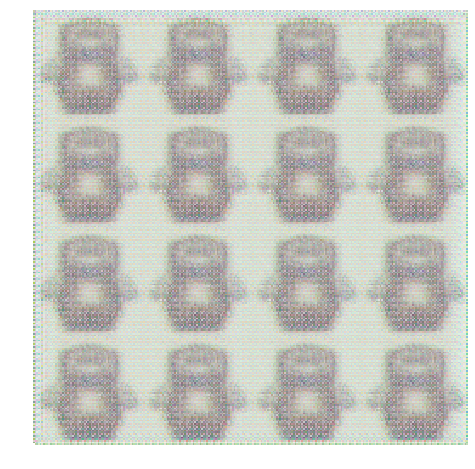

[2/15][1/11]	Loss_D: 0.6437	Loss_G: 28.1765	D(x): 0.6430	D(G(z)): 0.0950 / 0.5134
[2/15][2/11]	Loss_D: 1.3381	Loss_G: 29.2964	D(x): 0.9303	D(G(z)): 0.5940 / 0.0393
[2/15][3/11]	Loss_D: 0.9077	Loss_G: 28.6783	D(x): 0.5074	D(G(z)): 0.0625 / 0.0889
[2/15][4/11]	Loss_D: 0.4041	Loss_G: 25.4707	D(x): 0.7916	D(G(z)): 0.1321 / 0.2299
[2/15][5/11]	Loss_D: 0.5049	Loss_G: 26.6300	D(x): 0.9075	D(G(z)): 0.3062 / 0.0892
[2/15][6/11]	Loss_D: 0.2963	Loss_G: 24.8500	D(x): 0.8422	D(G(z)): 0.1039 / 0.0663
[2/15][7/11]	Loss_D: 0.3192	Loss_G: 24.3938	D(x): 0.8249	D(G(z)): 0.1072 / 0.1134
[2/15][8/11]	Loss_D: 0.3303	Loss_G: 23.1171	D(x): 0.9012	D(G(z)): 0.1934 / 0.0672
[2/15][9/11]	Loss_D: 0.3135	Loss_G: 23.4503	D(x): 0.8124	D(G(z)): 0.0840 / 0.0972
[2/15][10/11]	Loss_D: 0.3090	Loss_G: 22.4655	D(x): 0.8707	D(G(z)): 0.1449 / 0.1039
EPOCH4:
[3/15][0/11]	Loss_D: 0.3095	Loss_G: 21.7650	D(x): 0.8862	D(G(z)): 0.1574 / 0.0537
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

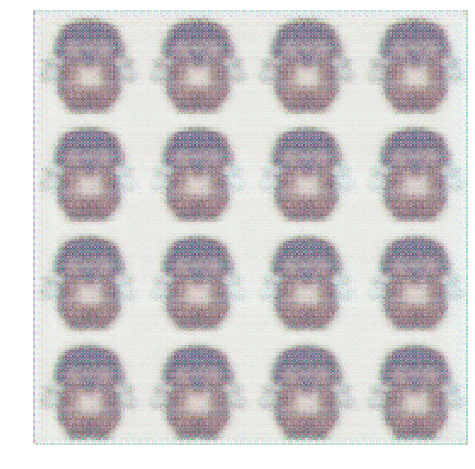

[3/15][1/11]	Loss_D: 0.2809	Loss_G: 20.7654	D(x): 0.8194	D(G(z)): 0.0703 / 0.1450
[3/15][2/11]	Loss_D: 0.2907	Loss_G: 22.1273	D(x): 0.9398	D(G(z)): 0.1957 / 0.0369
[3/15][3/11]	Loss_D: 0.4557	Loss_G: 17.0616	D(x): 0.6858	D(G(z)): 0.0491 / 0.7150
[3/15][4/11]	Loss_D: 1.0395	Loss_G: 21.0870	D(x): 0.9734	D(G(z)): 0.5888 / 0.0300
[3/15][5/11]	Loss_D: 2.6332	Loss_G: 18.5430	D(x): 0.1104	D(G(z)): 0.0274 / 0.1149
[3/15][6/11]	Loss_D: 0.7466	Loss_G: 17.8117	D(x): 0.6075	D(G(z)): 0.1302 / 0.4924
[3/15][7/11]	Loss_D: 0.9375	Loss_G: 18.3345	D(x): 0.9526	D(G(z)): 0.5186 / 0.1806
[3/15][8/11]	Loss_D: 0.4108	Loss_G: 18.8777	D(x): 0.9107	D(G(z)): 0.2457 / 0.0818
[3/15][9/11]	Loss_D: 0.3716	Loss_G: 19.2093	D(x): 0.7892	D(G(z)): 0.0951 / 0.0738
[3/15][10/11]	Loss_D: 0.4051	Loss_G: 16.9278	D(x): 0.7664	D(G(z)): 0.1065 / 0.1694
EPOCH5:
[4/15][0/11]	Loss_D: 0.4390	Loss_G: 18.0800	D(x): 0.9265	D(G(z)): 0.2733 / 0.0713
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

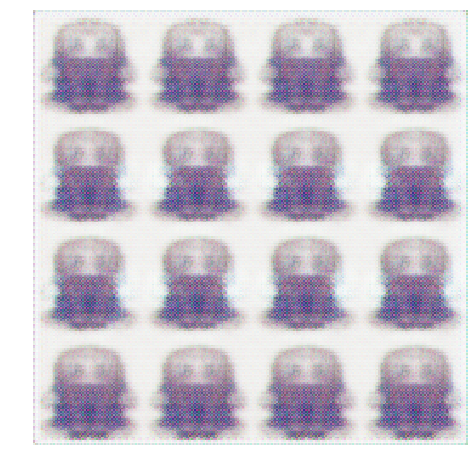

[4/15][1/11]	Loss_D: 0.2444	Loss_G: 18.0643	D(x): 0.8616	D(G(z)): 0.0834 / 0.0645
[4/15][2/11]	Loss_D: 0.2954	Loss_G: 16.3352	D(x): 0.8110	D(G(z)): 0.0648 / 0.1457
[4/15][3/11]	Loss_D: 1.0009	Loss_G: 18.1140	D(x): 0.9397	D(G(z)): 0.5177 / 0.0346
[4/15][4/11]	Loss_D: 2.0325	Loss_G: 16.2883	D(x): 0.2040	D(G(z)): 0.0260 / 0.1126
[4/15][5/11]	Loss_D: 0.4074	Loss_G: 14.9000	D(x): 0.8181	D(G(z)): 0.1495 / 0.3994
[4/15][6/11]	Loss_D: 0.7456	Loss_G: 15.7060	D(x): 0.9476	D(G(z)): 0.4405 / 0.0773
[4/15][7/11]	Loss_D: 0.6229	Loss_G: 16.2349	D(x): 0.6688	D(G(z)): 0.1054 / 0.1356
[4/15][8/11]	Loss_D: 0.3778	Loss_G: 15.5435	D(x): 0.8398	D(G(z)): 0.1581 / 0.1932
[4/15][9/11]	Loss_D: 0.3469	Loss_G: 16.4782	D(x): 0.9324	D(G(z)): 0.2222 / 0.0916
[4/15][10/11]	Loss_D: 0.3186	Loss_G: 15.9303	D(x): 0.8829	D(G(z)): 0.1647 / 0.0725
EPOCH6:
[5/15][0/11]	Loss_D: 0.3267	Loss_G: 15.4391	D(x): 0.7958	D(G(z)): 0.0814 / 0.1240
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


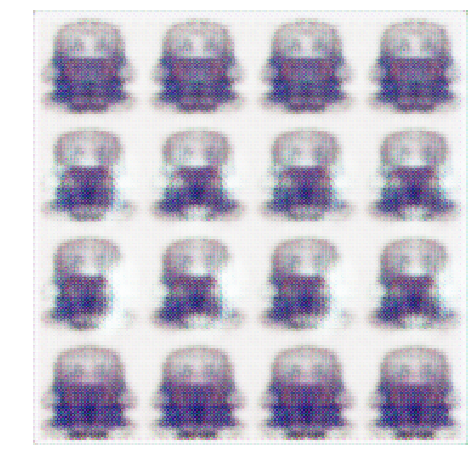

[5/15][1/11]	Loss_D: 0.3849	Loss_G: 15.5290	D(x): 0.8827	D(G(z)): 0.2044 / 0.1070
[5/15][2/11]	Loss_D: 0.2610	Loss_G: 14.6253	D(x): 0.8533	D(G(z)): 0.0901 / 0.1168
[5/15][3/11]	Loss_D: 0.6153	Loss_G: 16.6559	D(x): 0.9226	D(G(z)): 0.3737 / 0.0322
[5/15][4/11]	Loss_D: 1.5840	Loss_G: 13.1070	D(x): 0.2697	D(G(z)): 0.0381 / 0.5361
[5/15][5/11]	Loss_D: 1.0098	Loss_G: 14.8209	D(x): 0.9223	D(G(z)): 0.4864 / 0.0841
[5/15][6/11]	Loss_D: 0.9585	Loss_G: 13.7486	D(x): 0.5279	D(G(z)): 0.1134 / 0.2492
[5/15][7/11]	Loss_D: 0.5759	Loss_G: 14.1158	D(x): 0.8664	D(G(z)): 0.3187 / 0.1737
[5/15][8/11]	Loss_D: 0.4957	Loss_G: 13.7010	D(x): 0.7604	D(G(z)): 0.1641 / 0.2239
[5/15][9/11]	Loss_D: 0.4411	Loss_G: 13.8286	D(x): 0.8770	D(G(z)): 0.2448 / 0.1296
[5/15][10/11]	Loss_D: 0.3590	Loss_G: 14.5361	D(x): 0.8900	D(G(z)): 0.2063 / 0.0655
EPOCH7:
[6/15][0/11]	Loss_D: 0.4335	Loss_G: 13.3499	D(x): 0.7290	D(G(z)): 0.0857 / 0.2618
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


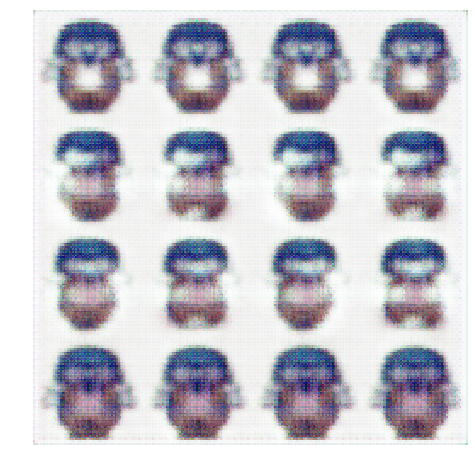

[6/15][1/11]	Loss_D: 0.5241	Loss_G: 15.0456	D(x): 0.9374	D(G(z)): 0.3511 / 0.0359
[6/15][2/11]	Loss_D: 0.8842	Loss_G: 12.5596	D(x): 0.4762	D(G(z)): 0.0438 / 0.4357
[6/15][3/11]	Loss_D: 0.7526	Loss_G: 14.7429	D(x): 0.9550	D(G(z)): 0.4896 / 0.0365
[6/15][4/11]	Loss_D: 1.0892	Loss_G: 12.4587	D(x): 0.4078	D(G(z)): 0.0609 / 0.2926
[6/15][5/11]	Loss_D: 0.3980	Loss_G: 12.7257	D(x): 0.9314	D(G(z)): 0.2679 / 0.1579
[6/15][6/11]	Loss_D: 0.3777	Loss_G: 13.1608	D(x): 0.8701	D(G(z)): 0.2014 / 0.1205
[6/15][7/11]	Loss_D: 0.4909	Loss_G: 12.6199	D(x): 0.7445	D(G(z)): 0.1600 / 0.2811
[6/15][8/11]	Loss_D: 0.4213	Loss_G: 12.9035	D(x): 0.8741	D(G(z)): 0.2347 / 0.1152
[6/15][9/11]	Loss_D: 0.4067	Loss_G: 12.6116	D(x): 0.8307	D(G(z)): 0.1889 / 0.1288
[6/15][10/11]	Loss_D: 0.3876	Loss_G: 11.6542	D(x): 0.7929	D(G(z)): 0.1299 / 0.2989
EPOCH8:
[7/15][0/11]	Loss_D: 0.8826	Loss_G: 14.8851	D(x): 0.9642	D(G(z)): 0.5446 / 0.0143
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


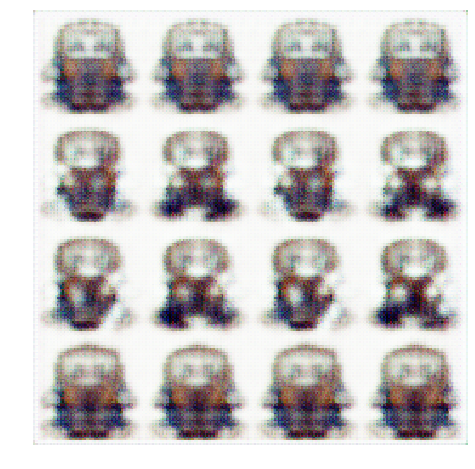

[7/15][1/11]	Loss_D: 3.2854	Loss_G: 12.8883	D(x): 0.0483	D(G(z)): 0.0141 / 0.0543
[7/15][2/11]	Loss_D: 1.7686	Loss_G: 12.0609	D(x): 0.2181	D(G(z)): 0.0541 / 0.6172
[7/15][3/11]	Loss_D: 1.1140	Loss_G: 11.3241	D(x): 0.9459	D(G(z)): 0.6047 / 0.2621
[7/15][4/11]	Loss_D: 0.6341	Loss_G: 10.8063	D(x): 0.7657	D(G(z)): 0.2783 / 0.2220
[7/15][5/11]	Loss_D: 0.5974	Loss_G: 11.8906	D(x): 0.8200	D(G(z)): 0.3039 / 0.2193
[7/15][6/11]	Loss_D: 0.6135	Loss_G: 10.9491	D(x): 0.7498	D(G(z)): 0.2526 / 0.2616
[7/15][7/11]	Loss_D: 0.6187	Loss_G: 12.2901	D(x): 0.8743	D(G(z)): 0.3572 / 0.1209
[7/15][8/11]	Loss_D: 0.5852	Loss_G: 10.8864	D(x): 0.6548	D(G(z)): 0.1182 / 0.2655
[7/15][9/11]	Loss_D: 0.6162	Loss_G: 12.7772	D(x): 0.9035	D(G(z)): 0.3868 / 0.1088
[7/15][10/11]	Loss_D: 0.5637	Loss_G: 11.4587	D(x): 0.6682	D(G(z)): 0.1319 / 0.2618
EPOCH9:
[8/15][0/11]	Loss_D: 0.4955	Loss_G: 11.8343	D(x): 0.8721	D(G(z)): 0.2908 / 0.1458
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


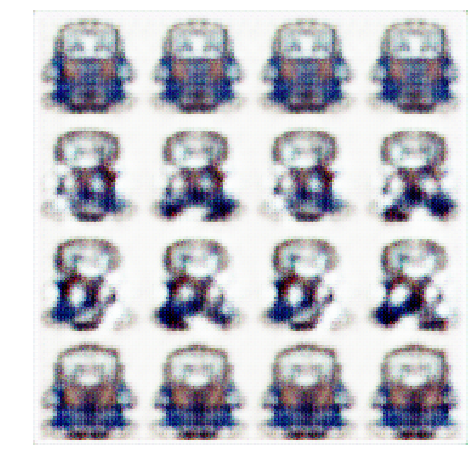

[8/15][1/11]	Loss_D: 0.4525	Loss_G: 11.2104	D(x): 0.7749	D(G(z)): 0.1667 / 0.2304
[8/15][2/11]	Loss_D: 0.5315	Loss_G: 12.2832	D(x): 0.8782	D(G(z)): 0.3149 / 0.0833
[8/15][3/11]	Loss_D: 0.8328	Loss_G: 9.8735	D(x): 0.5208	D(G(z)): 0.1019 / 0.6637
[8/15][4/11]	Loss_D: 1.2754	Loss_G: 12.9786	D(x): 0.9666	D(G(z)): 0.6847 / 0.0248
[8/15][5/11]	Loss_D: 2.6463	Loss_G: 11.5386	D(x): 0.1011	D(G(z)): 0.0217 / 0.0612
[8/15][6/11]	Loss_D: 1.0579	Loss_G: 9.5377	D(x): 0.4135	D(G(z)): 0.0668 / 0.6191
[8/15][7/11]	Loss_D: 1.1068	Loss_G: 11.7454	D(x): 0.9360	D(G(z)): 0.6136 / 0.2106
[8/15][8/11]	Loss_D: 0.5933	Loss_G: 11.1059	D(x): 0.8084	D(G(z)): 0.2943 / 0.1591
[8/15][9/11]	Loss_D: 0.6549	Loss_G: 10.2149	D(x): 0.6450	D(G(z)): 0.1626 / 0.2476
[8/15][10/11]	Loss_D: 0.5907	Loss_G: 10.2002	D(x): 0.7359	D(G(z)): 0.2224 / 0.3869
EPOCH10:
[9/15][0/11]	Loss_D: 0.7212	Loss_G: 10.4887	D(x): 0.9082	D(G(z)): 0.4420 / 0.1587
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


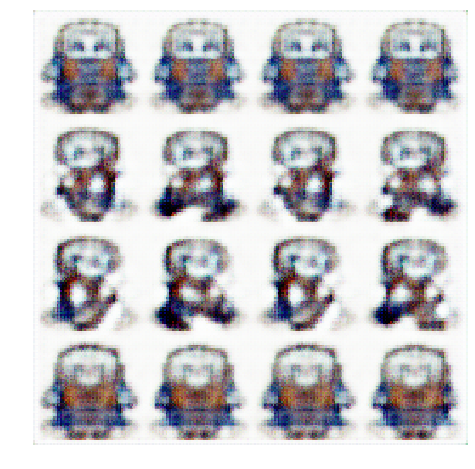

[9/15][1/11]	Loss_D: 0.6522	Loss_G: 10.9354	D(x): 0.7340	D(G(z)): 0.2473 / 0.1776
[9/15][2/11]	Loss_D: 0.5768	Loss_G: 9.3472	D(x): 0.7289	D(G(z)): 0.2011 / 0.3047
[9/15][3/11]	Loss_D: 0.5753	Loss_G: 10.8442	D(x): 0.9080	D(G(z)): 0.3666 / 0.1048
[9/15][4/11]	Loss_D: 0.7116	Loss_G: 9.3288	D(x): 0.5656	D(G(z)): 0.1123 / 0.4126
[9/15][5/11]	Loss_D: 0.7064	Loss_G: 11.0227	D(x): 0.9429	D(G(z)): 0.4591 / 0.0623
[9/15][6/11]	Loss_D: 0.8278	Loss_G: 10.2173	D(x): 0.5136	D(G(z)): 0.1146 / 0.3355
[9/15][7/11]	Loss_D: 0.5361	Loss_G: 10.6535	D(x): 0.8396	D(G(z)): 0.2905 / 0.2524
[9/15][8/11]	Loss_D: 0.5952	Loss_G: 11.4396	D(x): 0.8619	D(G(z)): 0.3513 / 0.0872
[9/15][9/11]	Loss_D: 1.0236	Loss_G: 9.9593	D(x): 0.4167	D(G(z)): 0.0875 / 0.6495
[9/15][10/11]	Loss_D: 1.1181	Loss_G: 12.0022	D(x): 0.9686	D(G(z)): 0.6394 / 0.0380
EPOCH11:
[10/15][0/11]	Loss_D: 1.5430	Loss_G: 9.8006	D(x): 0.2466	D(G(z)): 0.0396 / 0.1713
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.png',

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


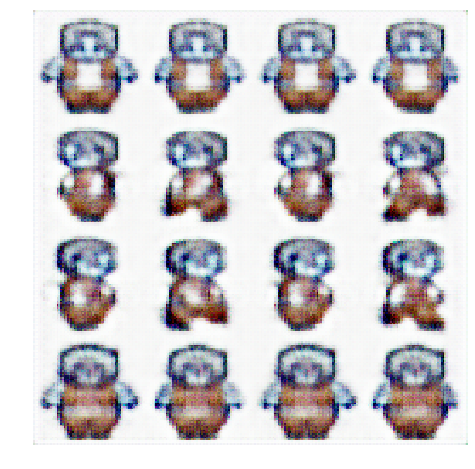

[10/15][1/11]	Loss_D: 0.5980	Loss_G: 9.7656	D(x): 0.7623	D(G(z)): 0.2666 / 0.5091
[10/15][2/11]	Loss_D: 0.8748	Loss_G: 11.0115	D(x): 0.9294	D(G(z)): 0.5394 / 0.0811
[10/15][3/11]	Loss_D: 1.3299	Loss_G: 9.2453	D(x): 0.3490	D(G(z)): 0.1121 / 0.2915
[10/15][4/11]	Loss_D: 0.7712	Loss_G: 9.5256	D(x): 0.7820	D(G(z)): 0.3680 / 0.3695
[10/15][5/11]	Loss_D: 0.6849	Loss_G: 9.4258	D(x): 0.7741	D(G(z)): 0.3268 / 0.2490
[10/15][6/11]	Loss_D: 0.6308	Loss_G: 9.6843	D(x): 0.7773	D(G(z)): 0.2981 / 0.2249
[10/15][7/11]	Loss_D: 0.5473	Loss_G: 9.4889	D(x): 0.7683	D(G(z)): 0.2313 / 0.2368
[10/15][8/11]	Loss_D: 0.5858	Loss_G: 10.3553	D(x): 0.7497	D(G(z)): 0.2411 / 0.3041
[10/15][9/11]	Loss_D: 0.8385	Loss_G: 10.1192	D(x): 0.7986	D(G(z)): 0.4397 / 0.1439
[10/15][10/11]	Loss_D: 0.8196	Loss_G: 9.2266	D(x): 0.5473	D(G(z)): 0.1587 / 0.5594
EPOCH12:
[11/15][0/11]	Loss_D: 0.9406	Loss_G: 11.0239	D(x): 0.9272	D(G(z)): 0.5610 / 0.0524
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


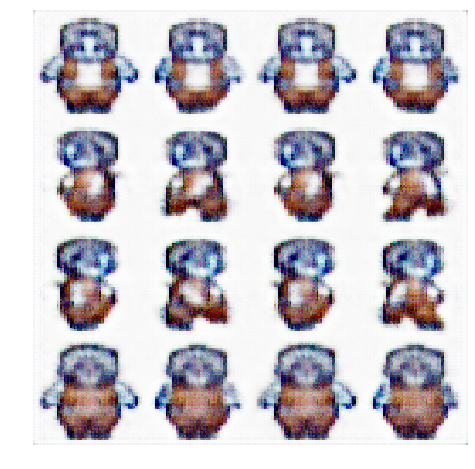

[11/15][1/11]	Loss_D: 1.8727	Loss_G: 8.7401	D(x): 0.1843	D(G(z)): 0.0661 / 0.3703
[11/15][2/11]	Loss_D: 0.6766	Loss_G: 9.2293	D(x): 0.8600	D(G(z)): 0.3897 / 0.2603
[11/15][3/11]	Loss_D: 0.8472	Loss_G: 9.4805	D(x): 0.7488	D(G(z)): 0.4039 / 0.1987
[11/15][4/11]	Loss_D: 0.7478	Loss_G: 9.3179	D(x): 0.5774	D(G(z)): 0.1453 / 0.4418
[11/15][5/11]	Loss_D: 0.9152	Loss_G: 10.6537	D(x): 0.9110	D(G(z)): 0.5388 / 0.0833
[11/15][6/11]	Loss_D: 1.1022	Loss_G: 9.4170	D(x): 0.4208	D(G(z)): 0.1443 / 0.3660
[11/15][7/11]	Loss_D: 0.6674	Loss_G: 9.1732	D(x): 0.7292	D(G(z)): 0.2704 / 0.5023
[11/15][8/11]	Loss_D: 0.7896	Loss_G: 9.9770	D(x): 0.8998	D(G(z)): 0.4736 / 0.0963
[11/15][9/11]	Loss_D: 0.7960	Loss_G: 9.1704	D(x): 0.5559	D(G(z)): 0.1512 / 0.3374
[11/15][10/11]	Loss_D: 0.8451	Loss_G: 8.3250	D(x): 0.6691	D(G(z)): 0.3362 / 0.5224
EPOCH13:
[12/15][0/11]	Loss_D: 1.1233	Loss_G: 11.2132	D(x): 0.9396	D(G(z)): 0.6315 / 0.0394
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


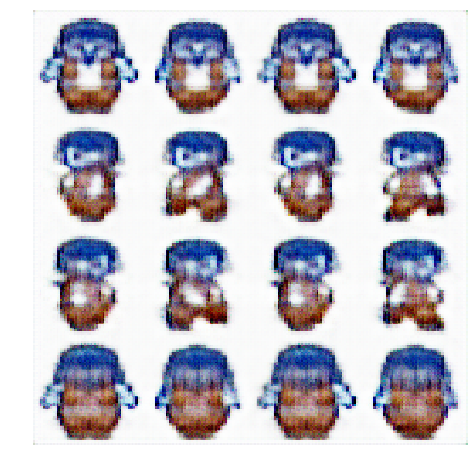

[12/15][1/11]	Loss_D: 1.9827	Loss_G: 9.6646	D(x): 0.1534	D(G(z)): 0.0387 / 0.1248
[12/15][2/11]	Loss_D: 0.9223	Loss_G: 7.7973	D(x): 0.4765	D(G(z)): 0.1378 / 0.7301
[12/15][3/11]	Loss_D: 1.4573	Loss_G: 8.9546	D(x): 0.9282	D(G(z)): 0.7300 / 0.1763
[12/15][4/11]	Loss_D: 0.8444	Loss_G: 9.5885	D(x): 0.5518	D(G(z)): 0.1897 / 0.2312
[12/15][5/11]	Loss_D: 0.7742	Loss_G: 7.9973	D(x): 0.6158	D(G(z)): 0.2249 / 0.4975
[12/15][6/11]	Loss_D: 0.8677	Loss_G: 9.0877	D(x): 0.8637	D(G(z)): 0.4944 / 0.1889
[12/15][7/11]	Loss_D: 0.9115	Loss_G: 8.1012	D(x): 0.5604	D(G(z)): 0.2534 / 0.3529
[12/15][8/11]	Loss_D: 0.8108	Loss_G: 8.1507	D(x): 0.7301	D(G(z)): 0.3743 / 0.3503
[12/15][9/11]	Loss_D: 0.8354	Loss_G: 9.6167	D(x): 0.8518	D(G(z)): 0.4623 / 0.1412
[12/15][10/11]	Loss_D: 1.2097	Loss_G: 8.0815	D(x): 0.3717	D(G(z)): 0.1255 / 0.4148
EPOCH14:
[13/15][0/11]	Loss_D: 0.8594	Loss_G: 9.1565	D(x): 0.9031	D(G(z)): 0.5132 / 0.1646
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


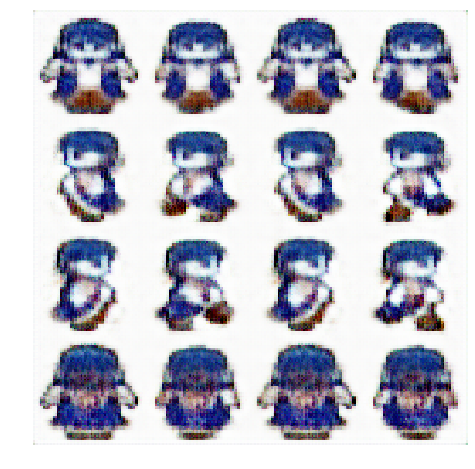

[13/15][1/11]	Loss_D: 0.7845	Loss_G: 8.3073	D(x): 0.5595	D(G(z)): 0.1558 / 0.2822
[13/15][2/11]	Loss_D: 0.7143	Loss_G: 8.9222	D(x): 0.7572	D(G(z)): 0.3396 / 0.3302
[13/15][3/11]	Loss_D: 0.6855	Loss_G: 8.0552	D(x): 0.7466	D(G(z)): 0.3092 / 0.2812
[13/15][4/11]	Loss_D: 0.7405	Loss_G: 8.3225	D(x): 0.7728	D(G(z)): 0.3697 / 0.2022
[13/15][5/11]	Loss_D: 0.8037	Loss_G: 7.9546	D(x): 0.5949	D(G(z)): 0.2317 / 0.4729
[13/15][6/11]	Loss_D: 1.1645	Loss_G: 10.1814	D(x): 0.8863	D(G(z)): 0.6273 / 0.0744
[13/15][7/11]	Loss_D: 1.9221	Loss_G: 8.4671	D(x): 0.1662	D(G(z)): 0.0656 / 0.2674
[13/15][8/11]	Loss_D: 1.0006	Loss_G: 7.0903	D(x): 0.5343	D(G(z)): 0.2795 / 0.7617
[13/15][9/11]	Loss_D: 1.2863	Loss_G: 8.6399	D(x): 0.9204	D(G(z)): 0.6749 / 0.1266
[13/15][10/11]	Loss_D: 0.7783	Loss_G: 8.7521	D(x): 0.5768	D(G(z)): 0.1827 / 0.2125
EPOCH15:
[14/15][0/11]	Loss_D: 0.9725	Loss_G: 7.1100	D(x): 0.4661	D(G(z)): 0.1531 / 0.5783
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


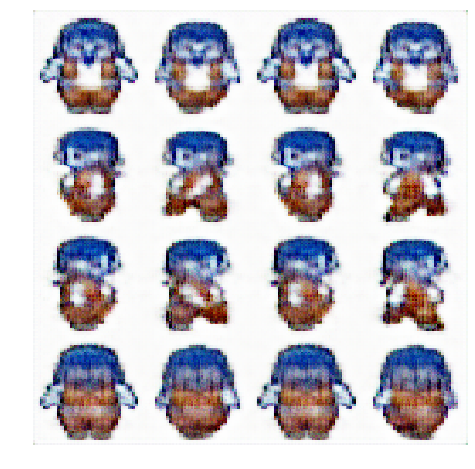

[14/15][1/11]	Loss_D: 1.3128	Loss_G: 8.5140	D(x): 0.8997	D(G(z)): 0.6822 / 0.1668
[14/15][2/11]	Loss_D: 0.9784	Loss_G: 7.8199	D(x): 0.5070	D(G(z)): 0.2360 / 0.2726
[14/15][3/11]	Loss_D: 1.1393	Loss_G: 6.7340	D(x): 0.4351	D(G(z)): 0.2080 / 0.6365
[14/15][4/11]	Loss_D: 1.0925	Loss_G: 9.4327	D(x): 0.9219	D(G(z)): 0.6152 / 0.1710
[14/15][5/11]	Loss_D: 0.6879	Loss_G: 8.8522	D(x): 0.6811	D(G(z)): 0.2474 / 0.1849
[14/15][6/11]	Loss_D: 0.8476	Loss_G: 8.0388	D(x): 0.5545	D(G(z)): 0.2061 / 0.4052
[14/15][7/11]	Loss_D: 0.8863	Loss_G: 8.6845	D(x): 0.8348	D(G(z)): 0.4776 / 0.2456
[14/15][8/11]	Loss_D: 0.7856	Loss_G: 7.9748	D(x): 0.6546	D(G(z)): 0.2824 / 0.2705
[14/15][9/11]	Loss_D: 0.8872	Loss_G: 7.4665	D(x): 0.5344	D(G(z)): 0.2008 / 0.5512
[14/15][10/11]	Loss_D: 1.1005	Loss_G: 8.3784	D(x): 0.8963	D(G(z)): 0.6127 / 0.1322
EPOCH16:
[15/15][0/11]	Loss_D: 0.7826	Loss_G: 8.4512	D(x): 0.5927	D(G(z)): 0.2116 / 0.2360
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


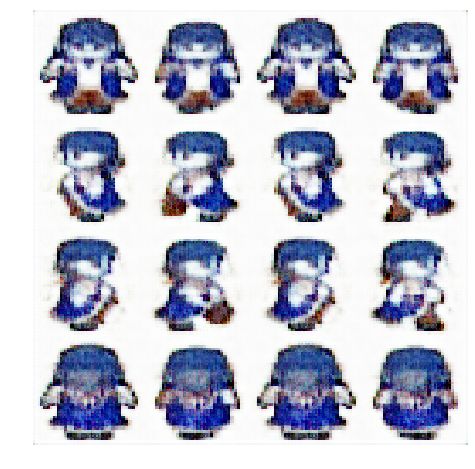

[15/15][1/11]	Loss_D: 0.9153	Loss_G: 7.4377	D(x): 0.5734	D(G(z)): 0.2838 / 0.4986
[15/15][2/11]	Loss_D: 0.7931	Loss_G: 6.8482	D(x): 0.6814	D(G(z)): 0.3235 / 0.4767
[15/15][3/11]	Loss_D: 0.9809	Loss_G: 8.7747	D(x): 0.8868	D(G(z)): 0.5561 / 0.0938
[15/15][4/11]	Loss_D: 1.2463	Loss_G: 7.5621	D(x): 0.3592	D(G(z)): 0.1571 / 0.3478
[15/15][5/11]	Loss_D: 0.7920	Loss_G: 7.0276	D(x): 0.6053	D(G(z)): 0.2337 / 0.6026
[15/15][6/11]	Loss_D: 1.0878	Loss_G: 9.2118	D(x): 0.8866	D(G(z)): 0.5965 / 0.1480
[15/15][7/11]	Loss_D: 0.9884	Loss_G: 7.8053	D(x): 0.5355	D(G(z)): 0.2626 / 0.2926
[15/15][8/11]	Loss_D: 1.1072	Loss_G: 6.7032	D(x): 0.4750	D(G(z)): 0.2269 / 0.5794
[15/15][9/11]	Loss_D: 1.2561	Loss_G: 8.9412	D(x): 0.9156	D(G(z)): 0.6734 / 0.1635
[15/15][10/11]	Loss_D: 0.8845	Loss_G: 7.8417	D(x): 0.5648	D(G(z)): 0.2388 / 0.2217
EPOCH17:
[16/15][0/11]	Loss_D: 1.1641	Loss_G: 6.6520	D(x): 0.4555	D(G(z)): 0.2732 / 0.5202
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


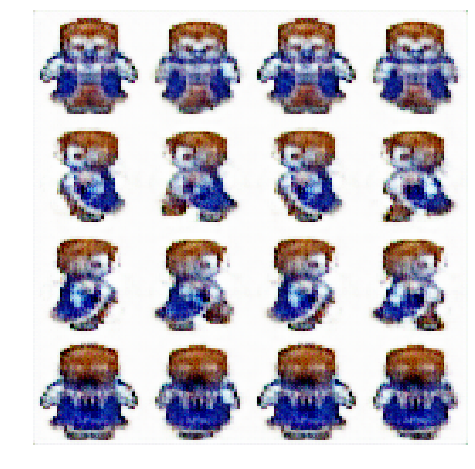

[16/15][1/11]	Loss_D: 0.7848	Loss_G: 7.4693	D(x): 0.6923	D(G(z)): 0.3136 / 0.4574
[16/15][2/11]	Loss_D: 1.4246	Loss_G: 8.2880	D(x): 0.9106	D(G(z)): 0.7114 / 0.1122
[16/15][3/11]	Loss_D: 1.5838	Loss_G: 7.6742	D(x): 0.2404	D(G(z)): 0.0886 / 0.2206
[16/15][4/11]	Loss_D: 1.0987	Loss_G: 6.9661	D(x): 0.4267	D(G(z)): 0.1833 / 0.7032
[16/15][5/11]	Loss_D: 1.9038	Loss_G: 7.4109	D(x): 0.9362	D(G(z)): 0.8267 / 0.2653
[16/15][6/11]	Loss_D: 1.1696	Loss_G: 7.2792	D(x): 0.4218	D(G(z)): 0.2273 / 0.2766
[16/15][7/11]	Loss_D: 0.9104	Loss_G: 7.4532	D(x): 0.6167	D(G(z)): 0.2909 / 0.3691
[16/15][8/11]	Loss_D: 0.8766	Loss_G: 7.6749	D(x): 0.7377	D(G(z)): 0.4099 / 0.3434
[16/15][9/11]	Loss_D: 0.7830	Loss_G: 7.8173	D(x): 0.6459	D(G(z)): 0.2722 / 0.3423
[16/15][10/11]	Loss_D: 0.9148	Loss_G: 7.1789	D(x): 0.7145	D(G(z)): 0.4050 / 0.3177
EPOCH18:
[17/15][0/11]	Loss_D: 0.8788	Loss_G: 7.7383	D(x): 0.7676	D(G(z)): 0.4396 / 0.2264
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


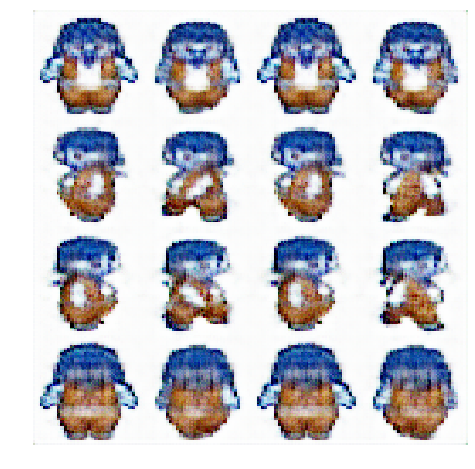

[17/15][1/11]	Loss_D: 0.9482	Loss_G: 7.1492	D(x): 0.5253	D(G(z)): 0.2260 / 0.3756
[17/15][2/11]	Loss_D: 0.8712	Loss_G: 7.5441	D(x): 0.7110	D(G(z)): 0.3838 / 0.3691
[17/15][3/11]	Loss_D: 0.8164	Loss_G: 8.1790	D(x): 0.8146	D(G(z)): 0.4425 / 0.1777
[17/15][4/11]	Loss_D: 0.8760	Loss_G: 7.1505	D(x): 0.5577	D(G(z)): 0.2335 / 0.3162
[17/15][5/11]	Loss_D: 1.0683	Loss_G: 6.4761	D(x): 0.5196	D(G(z)): 0.3158 / 0.5859
[17/15][6/11]	Loss_D: 0.9356	Loss_G: 7.4761	D(x): 0.8514	D(G(z)): 0.5249 / 0.1990
[17/15][7/11]	Loss_D: 0.9588	Loss_G: 6.7864	D(x): 0.4987	D(G(z)): 0.2108 / 0.3680
[17/15][8/11]	Loss_D: 0.8746	Loss_G: 7.3340	D(x): 0.7738	D(G(z)): 0.4461 / 0.2839
[17/15][9/11]	Loss_D: 1.0052	Loss_G: 6.7480	D(x): 0.5596	D(G(z)): 0.3275 / 0.3888
[17/15][10/11]	Loss_D: 1.0695	Loss_G: 6.8745	D(x): 0.6963	D(G(z)): 0.4932 / 0.2919
EPOCH19:
[18/15][0/11]	Loss_D: 0.9615	Loss_G: 6.3670	D(x): 0.5167	D(G(z)): 0.2421 / 0.4452
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


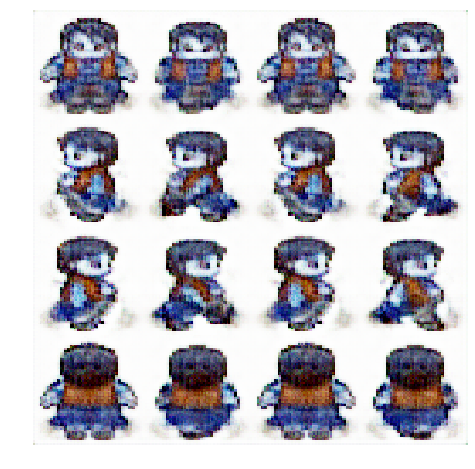

[18/15][1/11]	Loss_D: 1.0330	Loss_G: 6.7831	D(x): 0.7457	D(G(z)): 0.5104 / 0.2885
[18/15][2/11]	Loss_D: 1.0383	Loss_G: 6.2205	D(x): 0.5157	D(G(z)): 0.3001 / 0.4204
[18/15][3/11]	Loss_D: 0.8875	Loss_G: 7.5693	D(x): 0.7735	D(G(z)): 0.4573 / 0.2349
[18/15][4/11]	Loss_D: 0.9392	Loss_G: 7.2604	D(x): 0.5057	D(G(z)): 0.2000 / 0.4780
[18/15][5/11]	Loss_D: 0.9294	Loss_G: 7.5291	D(x): 0.7916	D(G(z)): 0.4827 / 0.2511
[18/15][6/11]	Loss_D: 0.8619	Loss_G: 6.8572	D(x): 0.6082	D(G(z)): 0.2935 / 0.3334
[18/15][7/11]	Loss_D: 0.8863	Loss_G: 7.9173	D(x): 0.7864	D(G(z)): 0.4588 / 0.1792
[18/15][8/11]	Loss_D: 0.9720	Loss_G: 6.6843	D(x): 0.4830	D(G(z)): 0.1950 / 0.4406
[18/15][9/11]	Loss_D: 0.9809	Loss_G: 7.2172	D(x): 0.7279	D(G(z)): 0.4707 / 0.2867
[18/15][10/11]	Loss_D: 1.2158	Loss_G: 6.6260	D(x): 0.4378	D(G(z)): 0.2944 / 0.5972
EPOCH20:
[19/15][0/11]	Loss_D: 1.2207	Loss_G: 7.7379	D(x): 0.8274	D(G(z)): 0.6190 / 0.1397
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


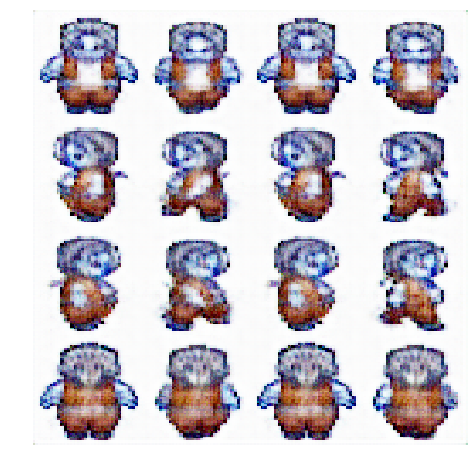

[19/15][1/11]	Loss_D: 1.4080	Loss_G: 6.1984	D(x): 0.3051	D(G(z)): 0.1631 / 0.4627
[19/15][2/11]	Loss_D: 0.9831	Loss_G: 6.3263	D(x): 0.6666	D(G(z)): 0.4221 / 0.4453
[19/15][3/11]	Loss_D: 0.8839	Loss_G: 7.3304	D(x): 0.7867	D(G(z)): 0.4551 / 0.2059
[19/15][4/11]	Loss_D: 1.0596	Loss_G: 6.4450	D(x): 0.5560	D(G(z)): 0.3548 / 0.3660
[19/15][5/11]	Loss_D: 0.9195	Loss_G: 6.6518	D(x): 0.5846	D(G(z)): 0.2811 / 0.4443
[19/15][6/11]	Loss_D: 0.8870	Loss_G: 7.1597	D(x): 0.6459	D(G(z)): 0.3471 / 0.4560
[19/15][7/11]	Loss_D: 1.0531	Loss_G: 7.4715	D(x): 0.8226	D(G(z)): 0.5516 / 0.1568
[19/15][8/11]	Loss_D: 1.2189	Loss_G: 6.5032	D(x): 0.4096	D(G(z)): 0.2341 / 0.4254
[19/15][9/11]	Loss_D: 0.9394	Loss_G: 6.9700	D(x): 0.6984	D(G(z)): 0.4210 / 0.3790
[19/15][10/11]	Loss_D: 0.8341	Loss_G: 7.0191	D(x): 0.7065	D(G(z)): 0.3678 / 0.2720
EPOCH21:
[20/15][0/11]	Loss_D: 1.0347	Loss_G: 6.3750	D(x): 0.5836	D(G(z)): 0.3667 / 0.3911
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


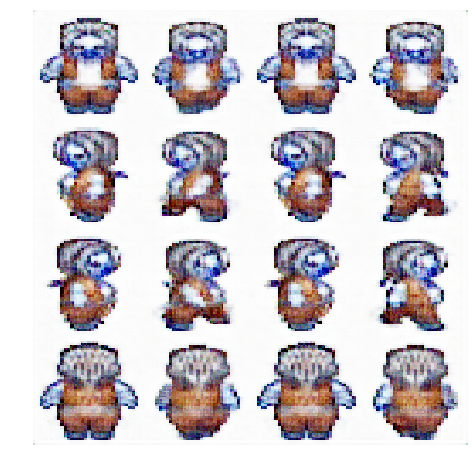

[20/15][1/11]	Loss_D: 0.9330	Loss_G: 7.1841	D(x): 0.5809	D(G(z)): 0.2918 / 0.4980
[20/15][2/11]	Loss_D: 1.0092	Loss_G: 7.7505	D(x): 0.8533	D(G(z)): 0.5573 / 0.1357
[20/15][3/11]	Loss_D: 0.9909	Loss_G: 6.5839	D(x): 0.4509	D(G(z)): 0.1560 / 0.3791
[20/15][4/11]	Loss_D: 0.9526	Loss_G: 6.3497	D(x): 0.6566	D(G(z)): 0.3917 / 0.4804
[20/15][5/11]	Loss_D: 1.1755	Loss_G: 6.9722	D(x): 0.7455	D(G(z)): 0.5577 / 0.2171
[20/15][6/11]	Loss_D: 1.2570	Loss_G: 6.2514	D(x): 0.3575	D(G(z)): 0.1654 / 0.5108
[20/15][7/11]	Loss_D: 1.0778	Loss_G: 6.5120	D(x): 0.7601	D(G(z)): 0.5339 / 0.3067
[20/15][8/11]	Loss_D: 0.9163	Loss_G: 7.4313	D(x): 0.6901	D(G(z)): 0.3976 / 0.2365
[20/15][9/11]	Loss_D: 0.8831	Loss_G: 6.7830	D(x): 0.6125	D(G(z)): 0.3018 / 0.3305
[20/15][10/11]	Loss_D: 1.0371	Loss_G: 6.0239	D(x): 0.4905	D(G(z)): 0.2557 / 0.6165
EPOCH22:
[21/15][0/11]	Loss_D: 1.1975	Loss_G: 7.7513	D(x): 0.8774	D(G(z)): 0.6390 / 0.1338
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


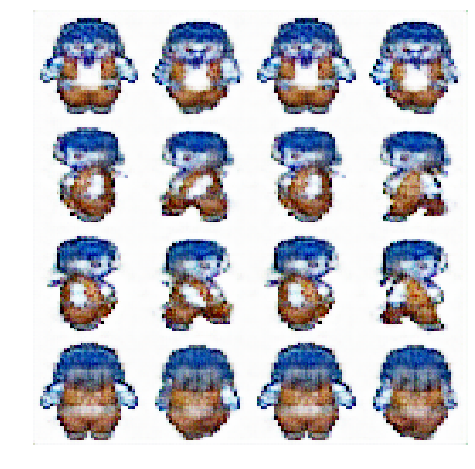

[21/15][1/11]	Loss_D: 1.3295	Loss_G: 6.4627	D(x): 0.3534	D(G(z)): 0.1637 / 0.3926
[21/15][2/11]	Loss_D: 0.9786	Loss_G: 6.0848	D(x): 0.6240	D(G(z)): 0.3816 / 0.5233
[21/15][3/11]	Loss_D: 1.0960	Loss_G: 6.5711	D(x): 0.6857	D(G(z)): 0.4899 / 0.3336
[21/15][4/11]	Loss_D: 0.7770	Loss_G: 6.9095	D(x): 0.6819	D(G(z)): 0.3139 / 0.2758
[21/15][5/11]	Loss_D: 0.8767	Loss_G: 7.3050	D(x): 0.7831	D(G(z)): 0.4539 / 0.1754
[21/15][6/11]	Loss_D: 0.9762	Loss_G: 6.1517	D(x): 0.4904	D(G(z)): 0.2178 / 0.4012
[21/15][7/11]	Loss_D: 1.1180	Loss_G: 5.8633	D(x): 0.5065	D(G(z)): 0.3326 / 0.6541
[21/15][8/11]	Loss_D: 1.1881	Loss_G: 6.6313	D(x): 0.7966	D(G(z)): 0.5982 / 0.2187
[21/15][9/11]	Loss_D: 0.9659	Loss_G: 6.3862	D(x): 0.5041	D(G(z)): 0.2237 / 0.3441
[21/15][10/11]	Loss_D: 0.9096	Loss_G: 7.4693	D(x): 0.7418	D(G(z)): 0.4358 / 0.2589
EPOCH23:
[22/15][0/11]	Loss_D: 1.1873	Loss_G: 5.7979	D(x): 0.4676	D(G(z)): 0.3077 / 0.5162
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


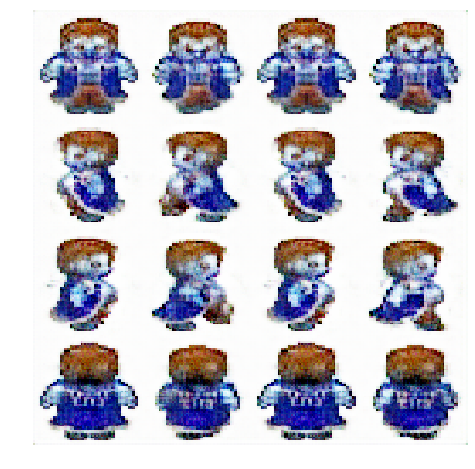

[22/15][1/11]	Loss_D: 1.0148	Loss_G: 5.7227	D(x): 0.6941	D(G(z)): 0.4654 / 0.3641
[22/15][2/11]	Loss_D: 0.9338	Loss_G: 7.5334	D(x): 0.7259	D(G(z)): 0.4382 / 0.2169
[22/15][3/11]	Loss_D: 1.0064	Loss_G: 6.0001	D(x): 0.5038	D(G(z)): 0.2532 / 0.4551
[22/15][4/11]	Loss_D: 1.0205	Loss_G: 7.1106	D(x): 0.8257	D(G(z)): 0.5482 / 0.1667
[22/15][5/11]	Loss_D: 1.1099	Loss_G: 6.2173	D(x): 0.4357	D(G(z)): 0.2251 / 0.4034
[22/15][6/11]	Loss_D: 0.9064	Loss_G: 5.8616	D(x): 0.5794	D(G(z)): 0.2877 / 0.5693
[22/15][7/11]	Loss_D: 1.2295	Loss_G: 6.9226	D(x): 0.7960	D(G(z)): 0.6128 / 0.1818
[22/15][8/11]	Loss_D: 1.1615	Loss_G: 5.9648	D(x): 0.4034	D(G(z)): 0.1891 / 0.4280
[22/15][9/11]	Loss_D: 0.9591	Loss_G: 6.4998	D(x): 0.7494	D(G(z)): 0.4679 / 0.3273
[22/15][10/11]	Loss_D: 0.9405	Loss_G: 6.2608	D(x): 0.6356	D(G(z)): 0.3651 / 0.3221
EPOCH24:
[23/15][0/11]	Loss_D: 1.1474	Loss_G: 5.4597	D(x): 0.5035	D(G(z)): 0.3309 / 0.5190
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


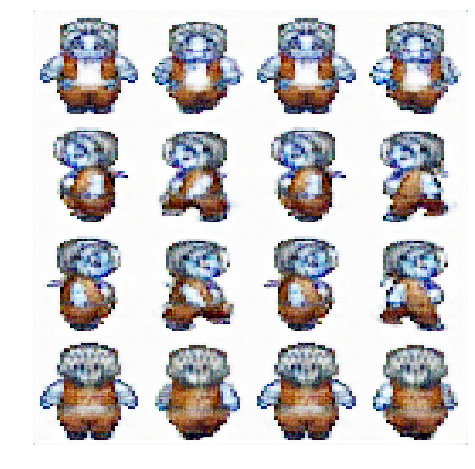

[23/15][1/11]	Loss_D: 1.1963	Loss_G: 7.1479	D(x): 0.8670	D(G(z)): 0.6266 / 0.1390
[23/15][2/11]	Loss_D: 1.4371	Loss_G: 6.3368	D(x): 0.3001	D(G(z)): 0.1555 / 0.3964
[23/15][3/11]	Loss_D: 0.9742	Loss_G: 5.7482	D(x): 0.6005	D(G(z)): 0.3398 / 0.5204
[23/15][4/11]	Loss_D: 1.1788	Loss_G: 5.8153	D(x): 0.7338	D(G(z)): 0.5521 / 0.3182
[23/15][5/11]	Loss_D: 1.0235	Loss_G: 6.6169	D(x): 0.6803	D(G(z)): 0.4158 / 0.2431
[23/15][6/11]	Loss_D: 1.1398	Loss_G: 6.1901	D(x): 0.4284	D(G(z)): 0.2150 / 0.4604
[23/15][7/11]	Loss_D: 1.0239	Loss_G: 5.8577	D(x): 0.7201	D(G(z)): 0.4696 / 0.3778
[23/15][8/11]	Loss_D: 1.0274	Loss_G: 6.0194	D(x): 0.6719	D(G(z)): 0.4245 / 0.2906
[23/15][9/11]	Loss_D: 0.9907	Loss_G: 6.5519	D(x): 0.5607	D(G(z)): 0.3049 / 0.3950
[23/15][10/11]	Loss_D: 1.1434	Loss_G: 5.8510	D(x): 0.5625	D(G(z)): 0.4004 / 0.4960
EPOCH25:
[24/15][0/11]	Loss_D: 1.0299	Loss_G: 5.5302	D(x): 0.6690	D(G(z)): 0.4394 / 0.3603
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


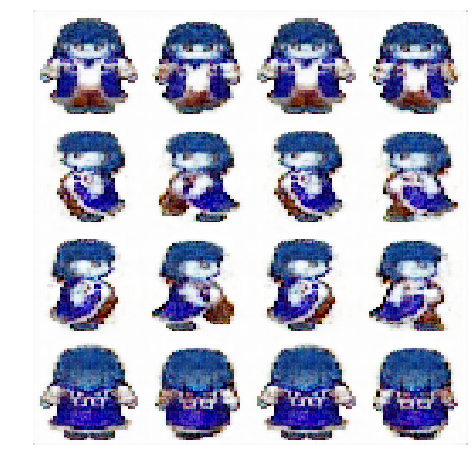

[24/15][1/11]	Loss_D: 0.8840	Loss_G: 5.8493	D(x): 0.7007	D(G(z)): 0.3867 / 0.2800
[24/15][2/11]	Loss_D: 1.0742	Loss_G: 5.8661	D(x): 0.5477	D(G(z)): 0.3377 / 0.4279
[24/15][3/11]	Loss_D: 1.0385	Loss_G: 6.6579	D(x): 0.8077	D(G(z)): 0.5355 / 0.1823
[24/15][4/11]	Loss_D: 1.2064	Loss_G: 5.7919	D(x): 0.3927	D(G(z)): 0.1734 / 0.4004
[24/15][5/11]	Loss_D: 1.1780	Loss_G: 5.2209	D(x): 0.5970	D(G(z)): 0.4415 / 0.5277
[24/15][6/11]	Loss_D: 1.0823	Loss_G: 6.5280	D(x): 0.7685	D(G(z)): 0.5331 / 0.2192
[24/15][7/11]	Loss_D: 0.9807	Loss_G: 6.4217	D(x): 0.5359	D(G(z)): 0.2705 / 0.3384
[24/15][8/11]	Loss_D: 1.0066	Loss_G: 6.0839	D(x): 0.5356	D(G(z)): 0.2818 / 0.5231
[24/15][9/11]	Loss_D: 1.1521	Loss_G: 6.2459	D(x): 0.7877	D(G(z)): 0.5751 / 0.2469
[24/15][10/11]	Loss_D: 0.9017	Loss_G: 6.3725	D(x): 0.6163	D(G(z)): 0.3138 / 0.2745
EPOCH26:
[25/15][0/11]	Loss_D: 0.9463	Loss_G: 5.7049	D(x): 0.6030	D(G(z)): 0.3380 / 0.3850
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


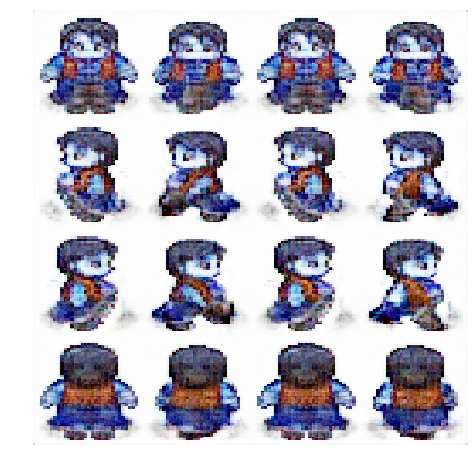

[25/15][1/11]	Loss_D: 0.9595	Loss_G: 6.0023	D(x): 0.6365	D(G(z)): 0.3764 / 0.3856
[25/15][2/11]	Loss_D: 1.1548	Loss_G: 5.1073	D(x): 0.5132	D(G(z)): 0.3357 / 0.5216
[25/15][3/11]	Loss_D: 1.0510	Loss_G: 5.8787	D(x): 0.7402	D(G(z)): 0.5128 / 0.2716
[25/15][4/11]	Loss_D: 1.1255	Loss_G: 5.5989	D(x): 0.4957	D(G(z)): 0.3003 / 0.4385
[25/15][5/11]	Loss_D: 0.9723	Loss_G: 5.6429	D(x): 0.6837	D(G(z)): 0.4263 / 0.3486
[25/15][6/11]	Loss_D: 0.9674	Loss_G: 6.1155	D(x): 0.6751	D(G(z)): 0.4200 / 0.2826
[25/15][7/11]	Loss_D: 0.9323	Loss_G: 6.0727	D(x): 0.6704	D(G(z)): 0.3952 / 0.2624
[25/15][8/11]	Loss_D: 1.1323	Loss_G: 6.0399	D(x): 0.4458	D(G(z)): 0.2214 / 0.5308
[25/15][9/11]	Loss_D: 1.1176	Loss_G: 6.4425	D(x): 0.8129	D(G(z)): 0.5780 / 0.2250
[25/15][10/11]	Loss_D: 1.3272	Loss_G: 5.1906	D(x): 0.3515	D(G(z)): 0.2167 / 0.4929
EPOCH27:
[26/15][0/11]	Loss_D: 1.0033	Loss_G: 5.4077	D(x): 0.6988	D(G(z)): 0.4521 / 0.4032
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


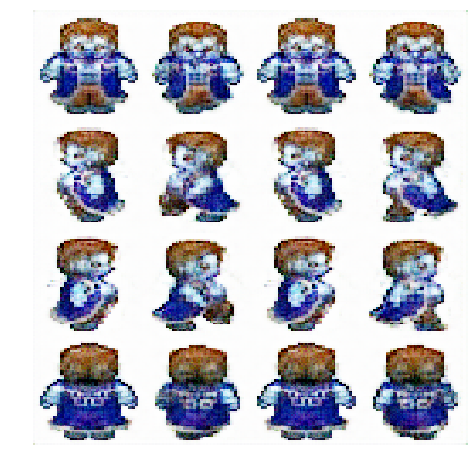

[26/15][1/11]	Loss_D: 1.0828	Loss_G: 7.2180	D(x): 0.7675	D(G(z)): 0.5188 / 0.1856
[26/15][2/11]	Loss_D: 1.0890	Loss_G: 6.2388	D(x): 0.4628	D(G(z)): 0.2468 / 0.3816
[26/15][3/11]	Loss_D: 0.9455	Loss_G: 5.3615	D(x): 0.6010	D(G(z)): 0.3365 / 0.4850
[26/15][4/11]	Loss_D: 1.0338	Loss_G: 5.7746	D(x): 0.6642	D(G(z)): 0.4440 / 0.3890
[26/15][5/11]	Loss_D: 1.0640	Loss_G: 6.4402	D(x): 0.7830	D(G(z)): 0.5424 / 0.1815
[26/15][6/11]	Loss_D: 1.4627	Loss_G: 5.4283	D(x): 0.3048	D(G(z)): 0.1818 / 0.4666
[26/15][7/11]	Loss_D: 1.0979	Loss_G: 4.9070	D(x): 0.6328	D(G(z)): 0.4475 / 0.4999
[26/15][8/11]	Loss_D: 1.0317	Loss_G: 5.9505	D(x): 0.7614	D(G(z)): 0.5079 / 0.2524
[26/15][9/11]	Loss_D: 1.1467	Loss_G: 5.1864	D(x): 0.4567	D(G(z)): 0.2730 / 0.4108
[26/15][10/11]	Loss_D: 1.0997	Loss_G: 5.6339	D(x): 0.5883	D(G(z)): 0.3985 / 0.4801
EPOCH28:
[27/15][0/11]	Loss_D: 1.2110	Loss_G: 5.6277	D(x): 0.7432	D(G(z)): 0.5799 / 0.2577
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


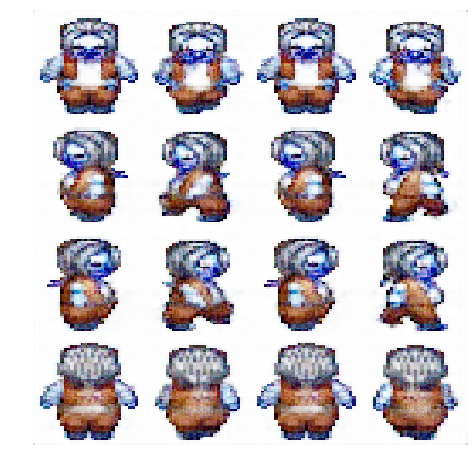

[27/15][1/11]	Loss_D: 1.1807	Loss_G: 5.2294	D(x): 0.3963	D(G(z)): 0.1958 / 0.4319
[27/15][2/11]	Loss_D: 1.1862	Loss_G: 5.1604	D(x): 0.6898	D(G(z)): 0.5348 / 0.3943
[27/15][3/11]	Loss_D: 0.9121	Loss_G: 6.0706	D(x): 0.6157	D(G(z)): 0.3278 / 0.3473
[27/15][4/11]	Loss_D: 1.0169	Loss_G: 5.3377	D(x): 0.6614	D(G(z)): 0.4356 / 0.3577
[27/15][5/11]	Loss_D: 0.9256	Loss_G: 5.6289	D(x): 0.6314	D(G(z)): 0.3514 / 0.3326
[27/15][6/11]	Loss_D: 0.9521	Loss_G: 5.4234	D(x): 0.6552	D(G(z)): 0.3994 / 0.3448
[27/15][7/11]	Loss_D: 1.1052	Loss_G: 5.1095	D(x): 0.5183	D(G(z)): 0.3390 / 0.4968
[27/15][8/11]	Loss_D: 1.0916	Loss_G: 5.8257	D(x): 0.7540	D(G(z)): 0.5407 / 0.2508
[27/15][9/11]	Loss_D: 1.1192	Loss_G: 5.3497	D(x): 0.4821	D(G(z)): 0.3054 / 0.4051
[27/15][10/11]	Loss_D: 0.9166	Loss_G: 5.7344	D(x): 0.6638	D(G(z)): 0.3829 / 0.3749
EPOCH29:
[28/15][0/11]	Loss_D: 0.9535	Loss_G: 5.2344	D(x): 0.6125	D(G(z)): 0.3607 / 0.4077
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


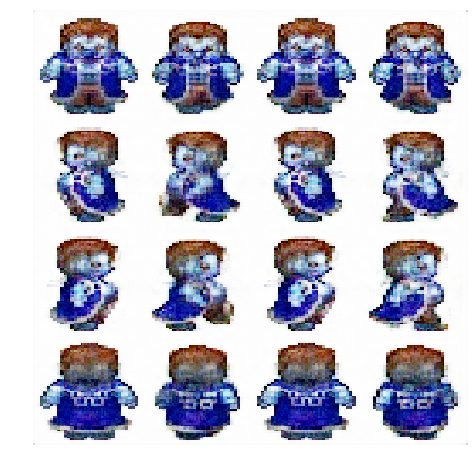

[28/15][1/11]	Loss_D: 1.1105	Loss_G: 5.9576	D(x): 0.6992	D(G(z)): 0.5145 / 0.2735
[28/15][2/11]	Loss_D: 1.0710	Loss_G: 5.3554	D(x): 0.4904	D(G(z)): 0.2554 / 0.4075
[28/15][3/11]	Loss_D: 0.9945	Loss_G: 5.7426	D(x): 0.6214	D(G(z)): 0.3744 / 0.4616
[28/15][4/11]	Loss_D: 1.0516	Loss_G: 6.1107	D(x): 0.7675	D(G(z)): 0.5288 / 0.2249
[28/15][5/11]	Loss_D: 0.9973	Loss_G: 5.7930	D(x): 0.5608	D(G(z)): 0.3301 / 0.3196
[28/15][6/11]	Loss_D: 1.2592	Loss_G: 4.7128	D(x): 0.4082	D(G(z)): 0.2812 / 0.6151
[28/15][7/11]	Loss_D: 1.0514	Loss_G: 5.9860	D(x): 0.7770	D(G(z)): 0.5359 / 0.2789
[28/15][8/11]	Loss_D: 1.0409	Loss_G: 5.6444	D(x): 0.5756	D(G(z)): 0.3616 / 0.3390
[28/15][9/11]	Loss_D: 1.0926	Loss_G: 4.9624	D(x): 0.5700	D(G(z)): 0.3919 / 0.4226
[28/15][10/11]	Loss_D: 1.0430	Loss_G: 5.3128	D(x): 0.5843	D(G(z)): 0.3785 / 0.4521
EPOCH30:
[29/15][0/11]	Loss_D: 1.1120	Loss_G: 6.3050	D(x): 0.8008	D(G(z)): 0.5693 / 0.1900
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


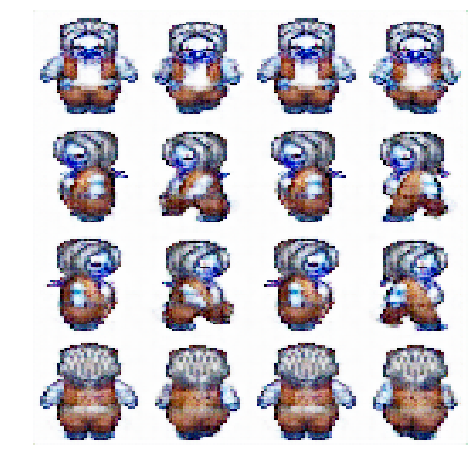

[29/15][1/11]	Loss_D: 1.3389	Loss_G: 4.9979	D(x): 0.3567	D(G(z)): 0.2338 / 0.4437
[29/15][2/11]	Loss_D: 0.9774	Loss_G: 5.0021	D(x): 0.5916	D(G(z)): 0.3404 / 0.5347
[29/15][3/11]	Loss_D: 1.0964	Loss_G: 5.4686	D(x): 0.7765	D(G(z)): 0.5546 / 0.2579
[29/15][4/11]	Loss_D: 1.0822	Loss_G: 5.2788	D(x): 0.5162	D(G(z)): 0.3258 / 0.3649
[29/15][5/11]	Loss_D: 1.1293	Loss_G: 4.8321	D(x): 0.6076	D(G(z)): 0.4457 / 0.3999
[29/15][6/11]	Loss_D: 1.0876	Loss_G: 5.0710	D(x): 0.5036	D(G(z)): 0.3100 / 0.5066
[29/15][7/11]	Loss_D: 0.9882	Loss_G: 5.7999	D(x): 0.7169	D(G(z)): 0.4627 / 0.3271
[29/15][8/11]	Loss_D: 1.0009	Loss_G: 5.8255	D(x): 0.6977	D(G(z)): 0.4564 / 0.2543
[29/15][9/11]	Loss_D: 1.1831	Loss_G: 5.1941	D(x): 0.4110	D(G(z)): 0.2286 / 0.5019
[29/15][10/11]	Loss_D: 1.2331	Loss_G: 5.5480	D(x): 0.7274	D(G(z)): 0.5802 / 0.3186
EPOCH31:
[30/15][0/11]	Loss_D: 1.1674	Loss_G: 4.9144	D(x): 0.4995	D(G(z)): 0.3617 / 0.3944
['F:\\KaliNode\\programming\\Project-Gaea\\Project-Gaea\\PyTorch_new/TestDataset\\108.pn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


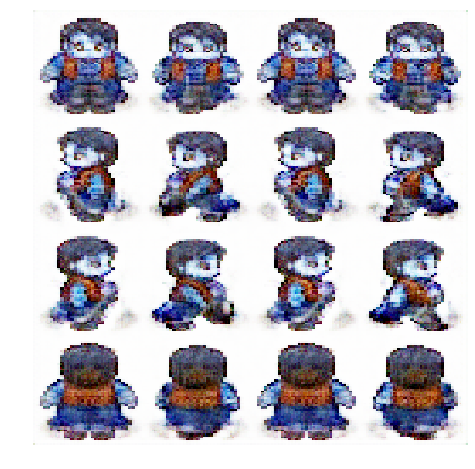

[30/15][1/11]	Loss_D: 1.1140	Loss_G: 4.6764	D(x): 0.6177	D(G(z)): 0.4520 / 0.3916
[30/15][2/11]	Loss_D: 1.1078	Loss_G: 4.9910	D(x): 0.5354	D(G(z)): 0.3389 / 0.4710


KeyboardInterrupt: 

In [163]:
fit(num_epochs=1000)

In [ ]:
torch.save(netG.state_dict(), 'G1.pth')
torch.save(netD.state_dict(), 'D1.pth')

In [ ]:
testpic()